# Extract cancer variant reads for alignment visualization

## In this notebook, we use a single RNA-seq fastq file from a melanoma cancer cell line from the the CCLE project. Learn more about the project here:
- sequencing data (ENA): https://www.ebi.ac.uk/ena/browser/view/PRJNA523380
- paper: https://www.nature.com/articles/s41586-019-1186-3

### Requirements: kb, samtools, and bowtie2

In [1]:
try:
    import varseek as vk
except ImportError:
    print("varseek not found, installing...")
    !pip install -U -q varseek
try:
    import RLSRWP_2025
except ImportError:
    print("RLSRWP_2025 not found, installing...")
    !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git

In [58]:
import anndata
import os
import numpy as np
import pandas as pd
import gget
import pyfastx
import glob
from tqdm import tqdm
# pd.set_option('display.max_columns', None)
import varseek as vk
from varseek.utils import make_bus_df, add_variant_type

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025
threads = "2"
use_head = False

### File path definitions and imports

In [3]:
vk_count_out_dir = os.path.join(RLSRWP_2025_dir, "data", "varseek_count_out_alignment_visualization_full")
kb_count_out_dir = os.path.join(vk_count_out_dir, "kb_count_out_vcrs")
adata_path = os.path.join(kb_count_out_dir, "counts_unfiltered", "adata.h5ad")
aligned_reads_parent_dir = os.path.join(vk_count_out_dir, "pseudoaligned_reads_to_vcrs_reference")
bowtie_read_alignments = os.path.join(vk_count_out_dir, "bowtie_read_alignments")

# vk ref out directory and files - downloaded if not already present
vk_ref_out_dir = os.path.join(RLSRWP_2025_dir, "data", "vk_ref_out")
vcrs_index = os.path.join(vk_ref_out_dir, "vcrs_index.idx")
vcrs_t2g = os.path.join(vk_ref_out_dir, "vcrs_t2g_filtered.txt")
vcrs_fasta = os.path.join(vk_ref_out_dir, "vcrs_filtered.fa")

# fastq directories - fastqs_dir downloaded if not already present, and fastqs_processed_dir created with fastp if not already present
fastqs_dir = os.path.join(RLSRWP_2025_dir, "data", "ccle_data_base", "RNASeq_MELHO_SKIN")
fastq_file = os.path.join(fastqs_dir, "SRR8615233_1.fastq.gz")
technology = "bulk"

# cosmic directory
cosmic_dir = os.path.join(RLSRWP_2025_dir, "data", "reference", "cosmic")
cosmic_csv = os.path.join(cosmic_dir, "CancerMutationCensus_AllData_Tsv_v101_GRCh37", "CancerMutationCensus_AllData_v101_GRCh37_mutation_workflow.csv")

# reference genome directory
reference_genome_dir = os.path.join(RLSRWP_2025_dir, "data", "reference", "ensembl_grch37_release93")

# kb count to reference genome directory and files - created if not already present - only used if qc_against_gene_matrix=True
qc_against_gene_matrix = False
kb_count_reference_genome_dir = os.path.join(RLSRWP_2025_dir, "data", "kb_count_reference_genome")
reference_genome_index = os.path.join(reference_genome_dir, "index.idx")  # either already exists or will be created
reference_genome_t2g = os.path.join(reference_genome_dir, "t2g.txt")  # either already exists or will be created
reference_genome_fasta = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.dna.primary_assembly.fa")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf
reference_genome_gtf = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.87.gtf")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf

# for bowtie2 - also uses reference_genome_fasta above (I could use cdna instead of genome too if desired)
bowtie_reference_dir = os.path.join(reference_genome_dir, "bowtie_index_genome")
bowtie_reference_prefix = os.path.join(bowtie_reference_dir, "index")

# general
w = "47"  # used during creation of the index, so cannot be altered
k = "51"  # used during creation of the index, so cannot be altered
strand = "unstranded"
parity = "single"  # although the original data is paired, we will only be using a single file, so we will run in single-end mode

# software
bustools = "/Users/joeyrich/miniconda3/envs/RLSRWP_2025/lib/python3.10/site-packages/kb_python/bins/darwin/m1/bustools/bustools"
bowtie2 = "bowtie2"
bowtie2_build = "bowtie2-build"
samtools = "samtools"

### Download VCRS reference files with varseek ref

In [4]:
if not os.path.exists(vcrs_index) or not os.path.exists(vcrs_t2g) or not os.path.exists(vcrs_fasta):
    vk.ref(variants="cosmic_cmc", sequences="cdna", w=w, k=k, dlist_reference_source="t2t", index_out=vcrs_index, t2g_out=vcrs_t2g, fasta_out=vcrs_fasta, download=True)

### Download COSMIC if not already downloaded

In [ ]:
if cosmic_csv and not os.path.isfile(cosmic_csv):
    gget.cosmic(
        None,
        grch_version=37,
        cosmic_version=101,
        out=cosmic_dir,
        mutation_class="cancer",
        download_cosmic=True,
        keep_genome_info=True,
        remove_duplicates=True
    )

cosmic_df = pd.read_csv(cosmic_csv)

if "mutation_cdna" not in cosmic_df.columns:
    reference_cdna_path = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.cdna.all.fa")
    reference_cds_path = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.cds.all.fa")
    if not os.path.exists(reference_cdna_path):
        reference_cdna_dir = os.path.dirname(reference_cdna_path) if os.path.dirname(reference_cdna_path) else "."
        !gget ref -w cdna -r 93 --out_dir {reference_cdna_dir} -d human_grch37
        !gunzip {reference_cdna_path}.gz
    if not os.path.exists(reference_cds_path):
        reference_cds_dir = os.path.dirname(reference_cds_path) if os.path.dirname(reference_cds_path) else "."
        !gget ref -w cdna -r 93 --out_dir {reference_cds_dir} -d human_grch37
        !gunzip {reference_cds_path}.gz
    print("Converting CDS to cDNA in COSMIC")
    cosmic_df, _ = vk.utils.convert_mutation_cds_locations_to_cdna(input_csv_path=cosmic_df, output_csv_path=cosmic_csv, cds_fasta_path=reference_cds_path, cdna_fasta_path=reference_cdna_path, verbose=True)

if "variant_type" not in cosmic_df.columns:
    add_variant_type(cosmic_df, "mutation_cdna")

if "header" not in cosmic_df.columns:
    cosmic_df["header"] = cosmic_df["seq_ID"] + ":" + cosmic_df["mutation_cdna"]
    cosmic_df.to_csv(cosmic_csv, index=False)

cosmic_df.head()

/var/folders/wr/wdr46lxn7fbc_kty6kwbfhxc0000gn/T/ipykernel_28337/1725634623.py:13: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  cosmic_df = pd.read_csv(cosmic_csv)


,seq_ID,mutation,mutation_aa,GENOMIC_MUTATION_ID,chromosome,strand,mutation_genome,gene_name,mutation_id,mutation_cdna,header
0,ENST00000396153,c.1468C>T,p.Q490*,COSV105286190,1,-,g.51001067G>A,FAF1,48293736,c.1920C>T,ENST00000396153:c.1920C>T
1,ENST00000445907,c.162C>A,p.L54=,COSV57765075,7,+,g.136699774C>A,CHRM2,60222372,c.690C>A,ENST00000445907:c.690C>A
2,ENST00000445907,c.617A>T,p.Y206F,COSV108138517,7,+,g.136700229A>T,CHRM2,60229878,c.1145A>T,ENST00000445907:c.1145A>T
3,ENST00000445907,c.93A>T,p.G31=,COSV100282253,7,+,g.136699705A>T,CHRM2,60227007,c.621A>T,ENST00000445907:c.621A>T
4,ENST00000445907,c.956A>C,p.N319T,COSV108138508,7,+,g.136700568A>C,CHRM2,60213402,c.1484A>C,ENST00000445907:c.1484A>C


### Make bowtie2 index files

In [8]:
if not os.path.exists(bowtie_reference_dir) or len(os.listdir(bowtie_reference_dir)) == 0:
    os.makedirs(bowtie_reference_dir, exist_ok=True)
    !{bowtie2_build} --threads {threads} {reference_genome_fasta} {bowtie_reference_prefix}

### Download fastq file

In [7]:
if not os.path.isfile(fastq_file):
    fastq_file_link = "ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR861/003/SRR8615233/SRR8615233_1.fastq.gz"  # ["ftp.sra.ebi.ac.uk/vol1/fastq/SRR861/003/SRR8615233/SRR8615233_1.fastq.gz", "ftp.sra.ebi.ac.uk/vol1/fastq/SRR861/003/SRR8615233/SRR8615233_2.fastq.gz"]
    os.makedirs(fastqs_dir, exist_ok=True)
    !wget -c --tries=5 --retry-connrefused -O {fastq_file} {fastq_file_link}

--2025-03-21 09:14:25--  ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR861/003/SRR8615233/SRR8615233_1.fastq.gz
           => ‘/Users/joeyrich/Desktop/local/RLSRWP_2025/data/ccle_data_base/RNASeq_MELHO_SKIN/SRR8615233_1.fastq.gz’
Resolving ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)|193.62.193.165|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /vol1/fastq/SRR861/003/SRR8615233 ... done.
==> SIZE SRR8615233_1.fastq.gz ... 3728501472
==> PASV ... done.    ==> RETR SRR8615233_1.fastq.gz ... done.
Length: 3728501472 (3.5G) (unauthoritative)

SRR8615233_1.fastq.  42%[=======>            ]   1.48G  --.-KB/s    in 31m 33s 

2025-03-21 09:46:01 (820 KB/s) - Data connection: Operation timed out; Control connection closed.
Retrying.

--2025-03-21 10:01:02--  ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR861/003/SRR8615233/SRR8615233_1.fastq.gz
  (try: 2) => ‘/Users/

In [10]:
if use_head:
    fastq_file_head = fastq_file.replace(".fastq.gz", "_head.fastq")
    if not os.path.isfile(fastq_file_head):
        !zcat {fastq_file} | head -1000000 > $fastq_file_head
    fastq_file = fastq_file_head

In [11]:
if not fastq_file.endswith(".gz"):
    !head {fastq_file}

### Make pyfastx index files

In [12]:
fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)
vcrs_fasta_indexed = pyfastx.Fasta(vcrs_fasta, build_index=True)

### Make kb reference files if qc_against_gene_matrix=True

In [14]:
kb_count_reference_genome_adata = os.path.join(kb_count_reference_genome_dir, "counts_unfiltered", "adata.h5ad")
if qc_against_gene_matrix and not os.path.exists(kb_count_reference_genome_adata):  # check if kb count was run
    os.makedirs(kb_count_reference_genome_dir, exist_ok=True)
    if not os.path.exists(reference_genome_index) or not os.path.exists(reference_genome_t2g):  # check if kb ref was run
        if not os.path.exists(reference_genome_fasta) or not os.path.exists(reference_genome_gtf):
            reference_genome_out_dir = os.path.dirname(reference_genome_fasta) if reference_genome_fasta else "."
            # using grch37, ensembl 93 to agree with COSMIC
            !gget ref -w dna,gtf -r 93 --out_dir {reference_genome_out_dir} -d human_grch37 && gunzip {reference_genome_fasta}.gz && gunzip {reference_genome_gtf}.gz
        reference_genome_f1 = os.path.join(kb_count_reference_genome_dir, "f1.fa")
        !kb ref -t {threads} -i {reference_genome_index} -g {reference_genome_t2g} -f1 {reference_genome_f1} {reference_genome_fasta} {reference_genome_gtf}

### Perform variant screening with varseek count

In [12]:
if not os.path.exists(adata_path):
    vk_count_output_dict = vk.count(
        fastq_file,
        index=vcrs_index,
        t2g=vcrs_t2g,
        technology=technology,
        out=vk_count_out_dir,
        k=k,
        strand=strand,
        parity=parity,
        threads=threads,
        disable_fastqpp=True,
        disable_clean=True,
        disable_summarize=True
        # quality_control_fastqs=True, cut_front=True, cut_tail=True  # equivalent to the fastp step above
        # qc_against_gene_matrix=qc_against_gene_matrix, reference_genome_index=reference_genome_index, reference_genome_t2g=reference_genome_t2g,
    )

10:04:58 - INFO - Setting length_required to 51 if fastqpp is run
10:04:58 - INFO - Skipping vk fastqpp because disable_fastqpp=True
10:04:58 - INFO - Running kb count with command: kb count -t 2 -k 51 -i /Users/joeyrich/Desktop/local/RLSRWP_2025/data/vk_ref_out/vcrs_index.idx -g /Users/joeyrich/Desktop/local/RLSRWP_2025/data/vk_ref_out/vcrs_t2g_filtered.txt -x BULK --h5ad -o /Users/joeyrich/Desktop/local/RLSRWP_2025/data/varseek_count_out_alignment_visualization_full/kb_count_out_vcrs --overwrite --strand unstranded --parity single --num /Users/joeyrich/Desktop/local/RLSRWP_2025/data/ccle_data_base/RNASeq_MELHO_SKIN/SRR8615233_1.fastq.gz
[2025-03-21 10:05:05,199]    INFO [count] Using index /Users/joeyrich/Desktop/local/RLSRWP_2025/data/vk_ref_out/vcrs_index.idx to generate BUS file to /Users/joeyrich/Desktop/local/RLSRWP_2025/data/varseek_count_out_alignment_visualization_full/kb_count_out_vcrs from
[2025-03-21 10:05:05,200]    INFO [count]         /Users/joeyrich/Desktop/local/RLSRW

### Load in adata object

In [96]:
adata = anndata.read_h5ad(adata_path)
adata

AnnData object with n_obs × n_vars = 1 × 5329695

### View top non-mitochondrial 15 variants by total reads aligned - 5 substitution, 5 deletion, 5 insertion

In [30]:
cosmic_df.head()

,seq_ID,mutation,mutation_aa,GENOMIC_MUTATION_ID,chromosome,strand,mutation_genome,gene_name,mutation_id,mutation_cdna,header
0,ENST00000396153,c.1468C>T,p.Q490*,COSV105286190,1,-,g.51001067G>A,FAF1,48293736,c.1920C>T,ENST00000396153:c.1920C>T
1,ENST00000445907,c.162C>A,p.L54=,COSV57765075,7,+,g.136699774C>A,CHRM2,60222372,c.690C>A,ENST00000445907:c.690C>A
2,ENST00000445907,c.617A>T,p.Y206F,COSV108138517,7,+,g.136700229A>T,CHRM2,60229878,c.1145A>T,ENST00000445907:c.1145A>T
3,ENST00000445907,c.93A>T,p.G31=,COSV100282253,7,+,g.136699705A>T,CHRM2,60227007,c.621A>T,ENST00000445907:c.621A>T
4,ENST00000445907,c.956A>C,p.N319T,COSV108138508,7,+,g.136700568A>C,CHRM2,60213402,c.1484A>C,ENST00000445907:c.1484A>C


In [99]:
# Map cosmic_df['gene_name'] to adata.var using 'header'
adata.var['header'] = adata.var_names
cosmic_df_gene_map = cosmic_df.drop_duplicates('header').set_index('header')[['gene_name', 'variant_type']]
adata.var = adata.var.merge(cosmic_df_gene_map, on='header', how='left').set_index(adata.var.index)
adata.var.index = adata.var['header']

# Filter out columns where gene_name starts with "mt-" (case-insensitive)
mask = ~adata.var['gene_name'].astype(str).str.upper().str.startswith('MT-', na=False)
adata = adata[:, mask]

In [126]:
number_to_select_per_mutation_type = 5
top15, top15_counts, top15_gene_names = [], [], []

for mutation_type in ["substitution", "insertion", "deletion"]:
    adata_tmp = adata[:, adata.var['variant_type'] == mutation_type].copy()  # select only mutation_type
    variants_list = list(adata_tmp.var.index[np.argsort(np.array(adata_tmp.X.todense())[0])][::-1][:number_to_select_per_mutation_type])
    top15.extend(variants_list)
    top15_counts.extend(list(np.array(adata_tmp.X.todense())[0][np.argsort(np.array(adata_tmp.X.todense())[0])][::-1][:number_to_select_per_mutation_type].astype(int)))
    top15_gene_names.extend(cosmic_df.set_index('header').loc[variants_list, 'gene_name'].tolist())

top15_dict = dict(zip(top15, top15_counts))

top15_df = pd.DataFrame({
    'Variant': top15,
    'Counts': top15_counts,
    'Gene_Name': top15_gene_names
})

top15 = top15_df.sort_values(by="Counts", ascending=False)["Variant"].tolist()  # sort descending order
top15_df = top15_df.sort_values(by="Counts", ascending=False).reset_index(drop=True)
top15_df

,Variant,Counts,Gene_Name
0,ENST00000398606:c.562A>G,13934,GSTP1
1,ENST00000449260:c.1988C>T,12589,PMEL
2,ENST00000251453:c.80T>G,11981,RPS16
3,ENST00000398606:c.804T>C,11300,GSTP1
4,ENST00000343262:c.156C>T,6296,RPS2
5,ENST00000322723:c.1024_1026del,2501,NCL
6,ENST00000263574:c.750_755del,254,APLP2
7,ENST00000367034:c.152_154del,216,MRPL18
8,ENST00000314222:c.448_449insCCCCC,145,PHLDA2
9,ENST00000373477:c.2126_2127insCGTAC,145,YARS


### Map the reads to the VCRS to which they aligned

In [103]:
bus_df = make_bus_df(kb_count_out_dir, fastq_file, technology=technology, parity=parity, bustools=bustools)
bus_df = bus_df.drop(columns=["transcript_names"]).rename(columns={"gene_names": "variant_names"})
filtered_bus_df = bus_df[bus_df["variant_names"].apply(lambda x: len(x) == 1)]  # remove multi-mapping reads
filtered_bus_df["variant_names_str"] = filtered_bus_df["variant_names"].apply(lambda x: x[0])  # cast to string
filtered_bus_df = filtered_bus_df[(filtered_bus_df["variant_names_str"].isin(top15)) & (filtered_bus_df["counted_in_count_matrix"])]
print(f"Number of reads in filtered bus file: {len(filtered_bus_df)}")
filtered_bus_df.head()

/var/folders/wr/wdr46lxn7fbc_kty6kwbfhxc0000gn/T/ipykernel_28337/3798617008.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_bus_df["variant_names_str"] = filtered_bus_df["variant_names"].apply(lambda x: x[0])  # cast to string


Number of reads in filtered bus file: 59719


,barcode,UMI,EC,read_index,fastq_header,file_index,variant_names,counted_in_count_matrix,variant_names_str
9665,AAAAAAAAAAAAAAAA,T,1702,917225,SRR8615233.917226,0,[ENST00000251453:c.80T>G],True,ENST00000251453:c.80T>G
9666,AAAAAAAAAAAAAAAA,T,1702,917227,SRR8615233.917228,0,[ENST00000251453:c.80T>G],True,ENST00000251453:c.80T>G
9667,AAAAAAAAAAAAAAAA,T,1702,917230,SRR8615233.917231,0,[ENST00000251453:c.80T>G],True,ENST00000251453:c.80T>G
9668,AAAAAAAAAAAAAAAA,T,1702,917231,SRR8615233.917232,0,[ENST00000251453:c.80T>G],True,ENST00000251453:c.80T>G
9669,AAAAAAAAAAAAAAAA,T,1702,917232,SRR8615233.917233,0,[ENST00000251453:c.80T>G],True,ENST00000251453:c.80T>G


In [127]:
# make IDs since the gene names in HGVSC format do not make for good folder names or bowtie2 header names
vcrs_header_to_id = {vcrs: f"vcrs_{i}" for i, vcrs in enumerate(list(top15))}
filtered_bus_df["vcrs_ids"] = filtered_bus_df["variant_names_str"].map(vcrs_header_to_id)

vcrs_header_to_id_file = os.path.join(vk_count_out_dir, "vcrs_header_to_id.txt")
with open(vcrs_header_to_id_file, "w") as f:
    for key, value in vcrs_header_to_id.items():
        f.write(f"{key}\t{value}\n")  # Tab-separated

id_to_vcrs_header = {v: k for k, v in vcrs_header_to_id.items()}
vcrs_header_to_id

{'ENST00000398606:c.562A>G': 'vcrs_0',
 'ENST00000449260:c.1988C>T': 'vcrs_1',
 'ENST00000251453:c.80T>G': 'vcrs_2',
 'ENST00000398606:c.804T>C': 'vcrs_3',
 'ENST00000343262:c.156C>T': 'vcrs_4',
 'ENST00000322723:c.1024_1026del': 'vcrs_5',
 'ENST00000263574:c.750_755del': 'vcrs_6',
 'ENST00000367034:c.152_154del': 'vcrs_7',
 'ENST00000314222:c.448_449insCCCCC': 'vcrs_8',
 'ENST00000373477:c.2126_2127insCGTAC': 'vcrs_9',
 'ENST00000434724:c.239_247del': 'vcrs_10',
 'ENST00000529010:c.1426_1428del': 'vcrs_11',
 'ENST00000262710:c.2258_2259insATTCAC': 'vcrs_12',
 'ENST00000372797:c.1497_1498insG': 'vcrs_13',
 'ENST00000435765:c.1262_1263insGTT': 'vcrs_14'}

In [128]:
for vcrs_id in sorted(filtered_bus_df["vcrs_ids"].unique()):  # Get unique gene names
    print(f"Processing {vcrs_id}")
    temp_df = filtered_bus_df[filtered_bus_df["vcrs_ids"] == vcrs_id]  # Filter
    fastq_headers = temp_df["fastq_header"].tolist()  # Get values as a list

    gene_dir = os.path.join(aligned_reads_parent_dir, vcrs_id)
    os.makedirs(gene_dir, exist_ok=True)
    
    aligned_reads_file = os.path.join(gene_dir, "1.fastq")
    with open(aligned_reads_file, "w") as f:
        for header in fastq_headers:
            sequence = fastq_indexed[header].seq
            qualities = fastq_indexed[header].qual
            f.write(f"@{header}\n{sequence}\n+\n{qualities}\n")

Processing vcrs_0
Processing vcrs_1
Processing vcrs_10
Processing vcrs_11
Processing vcrs_12
Processing vcrs_13
Processing vcrs_14
Processing vcrs_2
Processing vcrs_3
Processing vcrs_4
Processing vcrs_5
Processing vcrs_6
Processing vcrs_7
Processing vcrs_8
Processing vcrs_9


### View COSMIC metadata

In [129]:
cosmic_df_subset = cosmic_df[cosmic_df["header"].isin(top15)]
cosmic_df_subset["id"] = cosmic_df_subset["header"].map(vcrs_header_to_id)
cosmic_df_subset["counts"] = cosmic_df_subset["header"].map(lambda x: top15_dict[x])
cosmic_df_subset = cosmic_df_subset.sort_values(by="counts", ascending=False)
cosmic_df_subset

/var/folders/wr/wdr46lxn7fbc_kty6kwbfhxc0000gn/T/ipykernel_28337/2740002178.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cosmic_df_subset["id"] = cosmic_df_subset["header"].map(vcrs_header_to_id)
/var/folders/wr/wdr46lxn7fbc_kty6kwbfhxc0000gn/T/ipykernel_28337/2740002178.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cosmic_df_subset["counts"] = cosmic_df_subset["header"].map(lambda x: top15_dict[x])


,seq_ID,mutation,mutation_aa,GENOMIC_MUTATION_ID,chromosome,strand,mutation_genome,gene_name,mutation_id,mutation_cdna,header,variant_type,id,counts
5118134,ENST00000398606,c.313A>G,p.I105V,COSV66992376,11,+,g.67352689A>G,GSTP1,48379894,c.562A>G,ENST00000398606:c.562A>G,substitution,vcrs_0,13934
1545555,ENST00000449260,c.1977C>T,p.N659=,COSV59384225,12,-,g.56348028G>A,PMEL,60961346,c.1988C>T,ENST00000449260:c.1988C>T,substitution,vcrs_1,12589
4199446,ENST00000251453,c.27T>G,p.S9=,COSV52238647,19,-,g.39926509A>C,RPS16,21768506,c.80T>G,ENST00000251453:c.80T>G,substitution,vcrs_2,11981
5118182,ENST00000398606,c.555T>C,p.S185=,COSV66992478,11,+,g.67353970T>C,GSTP1,48379878,c.804T>C,ENST00000398606:c.804T>C,substitution,vcrs_3,11300
3224064,ENST00000343262,c.99C>T,p.I33=,COSV51909983,16,-,g.2014528G>A,RPS2,31955826,c.156C>T,ENST00000343262:c.156C>T,substitution,vcrs_4,6296
5239178,ENST00000322723,c.783_785del,p.D261del,COSV59544931,2,NaN,g.232325411_232325413del,NCL,26628001,c.1024_1026del,ENST00000322723:c.1024_1026del,deletion,vcrs_5,2501
5383497,ENST00000263574,c.678_683del,p.E226_E227del,COSV53838522,11,NaN,g.129991670_129991675del,APLP2,20079349,c.750_755del,ENST00000263574:c.750_755del,deletion,vcrs_6,254
5245332,ENST00000367034,c.30_32del,p.L10del,COSV58458382,6,NaN,g.160211649_160211651del,MRPL18,39042486,c.152_154del,ENST00000367034:c.152_154del,deletion,vcrs_7,216
3000122,ENST00000373477,c.1217_1218insCGTAC,p.Q408Rfs*15,COSV65114720,1,-,g.33245802_33245803insGTACG,YARS,39378578,c.2126_2127insCGTAC,ENST00000373477:c.2126_2127insCGTAC,insertion,vcrs_9,145
3767335,ENST00000314222,c.357_358insCCCCC,p.A120Pfs*50,COSV56542491,11,-,g.2950240_2950241insGGGGG,PHLDA2,27287821,c.448_449insCCCCC,ENST00000314222:c.448_449insCCCCC,insertion,vcrs_8,145


### Align (1) pulled out reads and (2) the VCRSs to the human genome to generate bam files:

In [130]:
for folder in sorted(glob.glob(aligned_reads_parent_dir + "/*/")):
    variant = folder.split("/")[-2]
    variant_header = id_to_vcrs_header[variant]
    print(f"{variant} ({variant_header})\n")

    outfolder = f"{bowtie_read_alignments}/{variant}"
    os.makedirs(outfolder, exist_ok=True)
    
    # Align reads to human ref using bowtie2
    variant_sam = variant + "_reads.sam"
    !$bowtie2 \
        --very-sensitive \
        -k 3 \
        -x $bowtie_reference_prefix \
        -p $threads \
        -q $aligned_reads_parent_dir/$variant/1.fastq \
        -S $outfolder/$variant_sam

    # Convert sam to bam
    variant_bam = variant + "_reads.bam"
    !$samtools view \
        -bS -F4 $outfolder/$variant_sam \
        > $outfolder/$variant_bam
    
    # Sort bam file
    variant_bam_sorted_prefix = "final_" + variant + "_sorted_reads"
    variant_bam_sorted = variant_bam_sorted_prefix + ".bam"
    !$samtools sort \
        $outfolder/$variant_bam \
        $outfolder/$variant_bam_sorted_prefix
    
    # Create an index for the sorted bam file (creates a .bai file)
    !$samtools index $outfolder/$variant_bam_sorted


    # repeat but use vcrs as the input instead of reads
    variant_reference_sequence = vcrs_fasta_indexed[variant_header].seq.strip()

    # Align vcrs to human ref using bowtie2
    variant_sam = variant + "_vcrs.sam"
    !$bowtie2 \
        --very-sensitive \
        -k 3 \
        -x $bowtie_reference_prefix \
        -p $threads \
        -c $variant_reference_sequence \
        -S $outfolder/$variant_sam
    # use k 3 to get multiple alignments, not just the best one

    # Convert sam to bam
    variant_bam = variant + "_vcrs.bam"
    !$samtools view \
        -bS -F4 $outfolder/$variant_sam \
        > $outfolder/$variant_bam

    # Sort bam file
    variant_bam_sorted_prefix = "final_" + variant + "_sorted_vcrs"
    variant_bam_sorted = variant_bam_sorted_prefix + ".bam"
    !$samtools sort \
        $outfolder/$variant_bam \
        $outfolder/$variant_bam_sorted_prefix

    # Create an index for the sorted bam file (creates a .bai file)
    !$samtools index $outfolder/$variant_bam_sorted

vcrs_0 (ENST00000398606:c.562A>G)

13934 reads; of these:
  13934 (100.00%) were unpaired; of these:
    6542 (46.95%) aligned 0 times
    7379 (52.96%) aligned exactly 1 time
    13 (0.09%) aligned >1 times
53.05% overall alignment rate
[samopen] SAM header is present: 84 sequences.
1 reads; of these:
  1 (100.00%) were unpaired; of these:
    1 (100.00%) aligned 0 times
    0 (0.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
0.00% overall alignment rate
[samopen] SAM header is present: 84 sequences.
vcrs_1 (ENST00000449260:c.1988C>T)

12589 reads; of these:
  12589 (100.00%) were unpaired; of these:
    39 (0.31%) aligned 0 times
    12550 (99.69%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
99.69% overall alignment rate
[samopen] SAM header is present: 84 sequences.
1 reads; of these:
  1 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    1 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate
[samopen]

### Load the files in bowtie_read_alignments into NCBI Genome workbench (or another genome viewer) to visualize the alignments (the ones with "final_")

ENST00000263574:c.750_755del is at the 24.76th percentile.


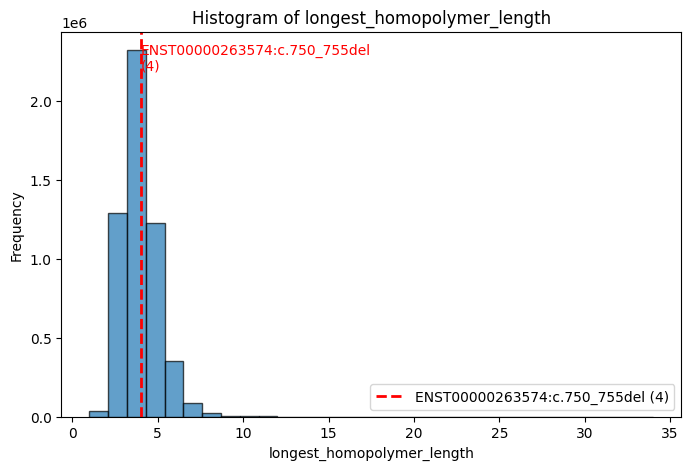

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from varseek.utils import longest_homopolymer

# Load the CSV and select relevant columns
file_path = "/Users/joeyrich/Desktop/local/RLSRWP_2025/data/vk_ref_out/variants_updated_filtered.csv"
df = pd.read_csv(file_path, usecols=["vcrs_header", "vcrs_sequence"])

(
df["longest_homopolymer_length"],
    df["longest_homopolymer"],
) = zip(*df["vcrs_sequence"].apply(lambda x: (longest_homopolymer(x) if pd.notna(x) else (np.nan, np.nan))))

# Define the target variant
target_header = "ENST00000263574:c.750_755del"

# Ensure longest_homopolymer_length is numeric
df = df.dropna(subset=["longest_homopolymer_length"])
df["longest_homopolymer_length"] = pd.to_numeric(df["longest_homopolymer_length"], errors="coerce")

# Get the target value
target_value = df.loc[df["vcrs_header"] == target_header, "longest_homopolymer_length"]

if target_value.empty:
    print(f"Header {target_header} not found in dataset.")
else:
    target_value = target_value.iloc[0]

    # Compute percentile
    percentile = (df["longest_homopolymer_length"] < target_value).mean() * 100
    print(f"{target_header} is at the {percentile:.2f}th percentile.")

    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.hist(df["longest_homopolymer_length"], bins=30, alpha=0.7, edgecolor="black")
    plt.axvline(target_value, color="red", linestyle="dashed", linewidth=2, label=f"{target_header} ({target_value})")
    
    # Annotate the target point
    plt.text(target_value, plt.ylim()[1] * 0.9, f"{target_header}\n({target_value})", color="red")

    # Labels and title
    plt.xlabel("longest_homopolymer_length")
    plt.ylabel("Frequency")
    plt.title("Histogram of longest_homopolymer_length")
    plt.legend()
    plt.show()


In [160]:
from scipy.stats import percentileofscore

value = 8
percentile = percentileofscore(df["longest_homopolymer_length"].dropna(), value, kind="rank")

print(f"Value {value} is at the {percentile:.4f}th percentile.")


Value 8 is at the 99.6286th percentile.
